In [1]:
from scipy import special
import matplotlib.pyplot as plt
from scipy import linalg

from svgutils import compose as sc

In [2]:
# %load mean_field_model.py
import attr
import numpy as np

# SI base units
s = 1
kg = 1
m = 1
A = 1

# derived units
S = s**3*A**2/(kg*m**2)
V = kg*m**2*s**-3*A**-1
F = s**4 * A**2 * m**-2 * kg ** -1
Hz = 1/s

# with prefixes
nS = 1e-9 * S
uS = 1e-6 * S
mV = 1e-3 * V
uV = 1e-6 * V
pF = 1e-12 * F
ms = 1e-3 * s
nA = 1e-9 * A
pA = 1e-12 * A


def kuhn_transfer_function(threshold, tau_eff, mu_u, sigma_sq_u):
    return 1. / (2 * tau_eff) * (special.erfc((threshold - mu_u) /
                                 (np.sqrt(2) * np.sqrt(sigma_sq_u))))


def derivative_kuhn_transfer_function(threshold, tau_eff,  mu_u, sigma_sq_u):
    return 1. / (2 * tau_eff * (np.sqrt(2 * sigma_sq_u)) * (2/ np.sqrt(np.pi)) *
                 np.exp(-(threshold - mu_u) ** 2 / (2 * sigma_sq_u)))


@attr.s
class EIMeanField:
    E_e = attr.ib(0 * mV)
    E_i = attr.ib(-75 * mV)
    E_l = attr.ib(-70 * mV)
    g_l = attr.ib(1./60 * uS)
    C = attr.ib(250 * pF)
    v_reset = attr.ib(-60 * mV)
    threshold = attr.ib(-50 * mV)
    threshold_inh = attr.ib(-53 * mV)
    tau_ref = attr.ib(2 * ms)
    T_e = attr.ib(0.2 * ms)  # width of excitatory PSC (ms)
    T_i = attr.ib(2 * ms)    # width of inhibitory PSC (ms)
    tau_e = attr.ib(1 * ms)  # timescale of excitatory population (ms)
    tau_i = attr.ib(0.5 * ms)    # timescale of inhibitory population (ms)
    B_e = attr.ib(7.1 * nS)    # peak excitatory conductance (nS)
    B_i = attr.ib(3.7 * nS)    # peak inhibitory conductance (nS)

    f_ext = attr.ib(5000 * Hz) # etracellular_firing_rate

    n_e = attr.ib(350.) # number of excitatory neurons
    n_i = attr.ib(350. / 4.) # number of inhibitory neurons

    noise_std_e = attr.ib(2000 * Hz / np.sqrt(s))
    noise_std_i = attr.ib(0 * Hz / np.sqrt(s))

    tau_adapt = attr.ib(800 * ms) # adaptation time constant
    beta_adapt = attr.ib(0.00005*mV / Hz) # strength of adaptation (per firing rate of E population)

    def calc_membrane_stats(self, fr_e, fr_i):

        mu_ge = fr_e * self.B_e * self.T_e * np.exp(1)
        mu_gi = fr_i * self.B_i * self.T_i * np.exp(1)

        gtot = self.g_l + mu_ge + mu_gi

        mu_u = (self.E_l * self.g_l + self.E_e * mu_ge + self.E_i * mu_gi) / gtot

        tau_eff = self.C / gtot

        epsp_int = (self.E_e - mu_u) * self.B_e * self.T_e * np.exp(1) * tau_eff / self.C
        ipsp_int = (self.E_i - mu_u) * (self.B_i * self.T_i * np.exp(1) * tau_eff / self.C)
        epsp_sq =  epsp_int ** 2 * (2 * tau_eff + self.T_e) /(4 * (tau_eff + self.T_e)**2)
        ipsp_sq =  ipsp_int ** 2 * (2 * tau_eff + self.T_i) /(4 * (tau_eff + self.T_i)**2)
        sigma_sq_u = fr_e * epsp_sq + fr_i * ipsp_sq

        return gtot, mu_u, tau_eff, sigma_sq_u



    def calc_output_rate_inh_exc(self, fr_e, fr_i, delta_v_e=0, delta_v_i=0):
        gtot_exc, mu_u_exc, tau_eff_exc, sigma_sq_u_exc = self.calc_membrane_stats(fr_e=fr_e, fr_i=fr_i)
        gtot_inh, mu_u_inh, tau_eff_inh, sigma_sq_u_inh = self.calc_membrane_stats(fr_e=fr_e, fr_i=fr_i)

        rexc = kuhn_transfer_function(self.threshold + delta_v_e, tau_eff_exc, mu_u_exc, sigma_sq_u_exc)
        rinh = kuhn_transfer_function(self.threshold_inh + delta_v_i, tau_eff_inh, mu_u_inh, sigma_sq_u_inh)

        return rexc * self.n_e, rinh * self.n_i

    def ode_step(self, dt, rexc, rinh, theta_adapt, dv_e=0, dv_i=0):
        fexc, finh = self.calc_output_rate_inh_exc(rexc + self.f_ext,
                              rinh, theta_adapt + dv_e, dv_i)
        theta_adapt = theta_adapt + ((-theta_adapt +
                 self.beta_adapt * rexc) *
                 dt / self.tau_adapt)
        rinh = rinh + (-rinh + finh) * dt / self.tau_i
        rexc = rexc + (-rexc + fexc) * dt / self.tau_e


        return rexc, rinh, theta_adapt

    def sde_step(self, dt, rexc, rinh, theta_adapt, dv_e=0, dv_i=0):
        rexc, rinh, theta_adapt = self.ode_step(dt, rexc, rinh, theta_adapt, dv_e, dv_i)
        rexc += np.random.randn() * self.noise_std_e * np.sqrt(dt)
        rinh += np.random.randn() * self.noise_std_i * np.sqrt(dt)
        rexc = np.maximum(rexc, 0)
        rinh = np.maximum(rinh, 0)

        return rexc, rinh, theta_adapt


# Single population model

In [3]:
tau_adapt = 800 * ms # adaptation time constant
beta_adapt = 0.00005*mV / Hz # strength of adaptation (per firing rate of E population)
dt = 1. * ms # integration time step
tau_e = 10*ms # time constant of excitatory population
tau_i = 5* ms # time constant of inhibitory population
threshold_inh0 = -51 * mV # inhibitory threshold
noise_e = 2000 * Hz / s 
tmax = 20 * s
f_ext = 1000 * Hz

gamma_ephaptic = 10 * uV / (6000*Hz) # ephaptic coupling coefficient
threshold = 4000 * Hz
tmax = 500 * s

In [4]:
model = EIMeanField(tau_adapt=tau_adapt,
                    beta_adapt=beta_adapt,
                    tau_e=tau_e,
                    tau_i=tau_i,
                    threshold_inh=threshold_inh0,
                    noise_std_e=noise_e,
                    noise_std_i=0,
                    f_ext=f_ext
                    )

## Network

In [5]:
def run_two_dimensional_sheet(tmax, model, C):
    
    n_nodes = C.shape[0]
    states = np.zeros((n_nodes, 3))
    states[:, :2] = 100 * Hz
    new_states = np.empty((n_nodes, 3))

    t = 0
    solution = []
    while t < tmax:
        new_states.fill(0)
        for i in range(n_nodes):
            field_coupling = np.sum(C[i, :] * states[:, 0])
            new_states[i, :] = model.sde_step(dt, *states[i, :], -field_coupling)

        t += dt
        solution.append(new_states.copy())
        states = new_states.copy()
    solution = np.array(solution)
    time = np.arange(solution.shape[0]) * dt
    return time, solution

In [6]:
def calc_correlation_matrix(solution, threshold):
    corr_mat = np.corrcoef((solution[:, :, 0]>threshold).T)
    ij = np.arange(corr_mat.shape[0])
    corr_mat[ij, ij] = 0
    return corr_mat
    
def plot_correlation_matrix(corr_mat, corr_mean):

    corr_max = np.abs(corr_mat).max()
    fig_corr_ring = plt.figure(facecolor='none')
    ax = plt.subplot(111)
    mappable = ax.matshow(corr_mat, cmap=plt.cm.BrBG_r, vmin=-corr_max, vmax=corr_max)
    cb = plt.colorbar(mappable)
    cb.set_label('correlation coefficient')
    ax.text(0.9, 0.8, '$\\bar{{r}}={:.3f}$'.format(corr_mean), size=15,
              transform=ax.transAxes, ha='right')
    return fig_corr_ring

## Calculate PLI

In [7]:
from scipy import signal

def calc_pli(solution, dt, n_subsamp=100, filter_order=5, cutoff_frequency=1):
    """Calculate the phase locking index (PLI)"""
    # subsample signal
    y = solution[::n_subsamp, :, 0].copy()
    
    # filter signal
    sampling_frequency = 1 / (dt * n_subsamp)
    b, a = signal.iirfilter(filter_order,  cutoff_frequency * 2 / sampling_frequency, btype='lowpass')
    y_filtered = signal.filtfilt(b, a, y[:], axis=0)
    phases = np.angle(signal.hilbert(y_filtered, axis=0))
    
    # calculate pairwise phase locking indice
    pli = np.abs(np.mean(np.exp((phases[:, :, None] - phases[:, None, :])*1j), axis=0))
    
    # zero out the diagonal for better visualisation
    ij = np.arange(pli.shape[0])
    pli[ij, ij] = np.NaN
    return pli

def plot_pli_matrix(pli, corr_mean):

    fig_corr_ring = plt.figure(facecolor='none')
    ax = plt.subplot(111)
    mappable = ax.matshow(pli)
    cb = plt.colorbar(mappable)
    cb.set_label('phase locking index')
    ax.text(0.9, 0.8, '$\\bar{{\Phi}}={:.3f}$'.format(corr_mean), size=15,
              transform=ax.transAxes, ha='right')
    return fig_corr_ring

## Linear chain

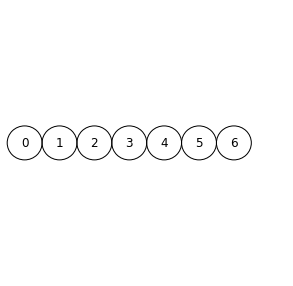

In [8]:
%run chain.py

In [9]:
chain_connectivity = linalg.toeplitz([0, 1, 0, 0, 0, 0, 0]) # nxn matrix connected to the next one
fig_chain_connectivity = plt.figure()
plt.spy(chain_connectivity)
plt.close()

In [10]:
time, solution_chain = run_two_dimensional_sheet(tmax, model, chain_connectivity * gamma_ephaptic)

In [11]:
corr_mat_chain = calc_correlation_matrix(solution_chain, threshold)
mean_corr_chain = corr_mat_chain[chain_connectivity == 1].mean()
fig_corr_chain = plot_correlation_matrix(corr_mat_chain, mean_corr_chain)
plt.close()

In [12]:
pli_chain = calc_pli(solution_chain, dt, cutoff_frequency=0.8)
mean_pli_chain = pli_chain[chain_connectivity==1].mean()
fig_pli_chain = plot_pli_matrix(pli_chain, mean_pli_chain)
plt.close()

In [13]:
svg = sc.Figure('15cm', '12cm',sc.SVG('chain.svg').scale(0.7).move(20, 30),
                              sc.MplFigure(fig_corr_chain, transparent=True)
                                 .scale(0.75).move(-40, 220),
                              sc.MplFigure(fig_chain_connectivity, transparent=True)
                                 .scale(0.75).move(250, 20),
                              sc.MplFigure(fig_pli_chain, transparent=True)
                                 .scale(0.75).move(250, 220),
                              sc.Text('A', 10, 50, size=18, weight='bold'),
                              sc.Text('B', 280, 50, size=18, weight='bold'),
                              sc.Text('C', 10, 250, size=18, weight='bold'),
                              sc.Text('D', 280, 250, size=18, weight='bold')                            

               )
svg

**Figure** Ephaptic-based synchronisation in the chain topology (one dimensional). **A**. We simulated seven E/I populations (labeled 0 &mdash; 6) connected in a chain. The populations interacted through electric field (ephaptic interaction) with their closest neighbours. **B**. Connectivity matrix. Black squares denote connected pairs. **C**. Pairwise correlation matrix between all pairs of populations. Largest correlations are with the closest neigbours (dark brown). The mean correlation between direct neigbours, $\bar{r}$, is given in the top-right corner. **D**. Phase locking index across all pairs and its average across connected pairs, $\bar{\Phi}$.

## Ring layout

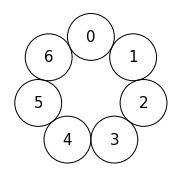

In [14]:
%run ring.py

In [15]:
ring_connectivity = linalg.circulant([0,1,0,0,0,0,1])
fig_ring_connectivity = plt.figure()
plt.spy(ring_connectivity)
plt.close()

In [16]:
time, solution_ring = run_two_dimensional_sheet(tmax, model, ring_connectivity * gamma_ephaptic)

([], [])

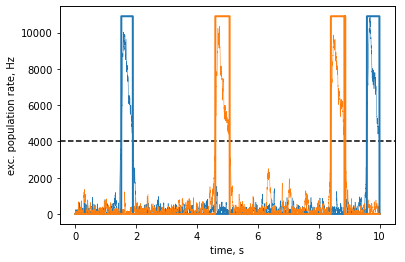

In [17]:
plt.plot(time[time < 10 * s], solution_ring[time<10*s, 0:2, 0],
         lw=0.5)
plt.ylabel('exc. population rate, Hz')
plt.xlabel('time, s')
plt.axhline(threshold, color='k', ls='--')
plt.twinx()
plt.plot(time[time < 10 * s], solution_ring[time<10*s, 0:2, 0] > threshold,
         lw=2)
plt.yticks([])

In [18]:
corr_mat_ring = calc_correlation_matrix(solution_ring, threshold)
mean_corr_ring = corr_mat_ring[ring_connectivity == 1].mean()
fig_corr_ring = plot_correlation_matrix(corr_mat_ring, mean_corr_ring)
plt.close()

In [19]:
pli_ring = calc_pli(solution_ring, dt, cutoff_frequency=0.8)
mean_pli_ring = pli_ring[ring_connectivity==1].mean()
fig_pli_ring = plot_pli_matrix(pli_ring, mean_pli_ring)
plt.close()

In [20]:
svg = sc.Figure('15cm', '12cm',sc.SVG('ring.svg').scale(0.9).move(20, 30),
                              sc.MplFigure(fig_corr_ring, transparent=True)
                                 .scale(0.75).move(-40, 220),
                              sc.MplFigure(fig_ring_connectivity, transparent=True)
                                 .scale(0.75).move(250, 20),
                              sc.MplFigure(fig_pli_ring, transparent=True)
                                 .scale(0.75).move(250, 220),
                              sc.Text('A', 10, 50, size=18, weight='bold'),
                              sc.Text('B', 280, 50, size=18, weight='bold'),
                              sc.Text('C', 10, 250, size=18, weight='bold'),
                              sc.Text('D', 280, 250, size=18, weight='bold')                            

               )
svg

**Figure** Ephaptic-based synchronisation in the ring topology (one dimensional). **A**. We simulated seven E/I populations (labeled 0 &mdash; 6) connected in a ring. The populations interacted through electric field (ephaptic interaction) with their closest neighbours. **B**. Connectivity matrix. Black squares denote connected pairs. **C**. Pairwise correlation matrix between all pairs of populations. Largest correlations are with the closest neigbours (dark brown). The mean correlation between direct neigbours, $\bar{r}$, is given in the top-right corner. **D**. Phase locking index across all pairs and its average across connected pairs, $\bar{\Phi}$.

## Hexagonal map

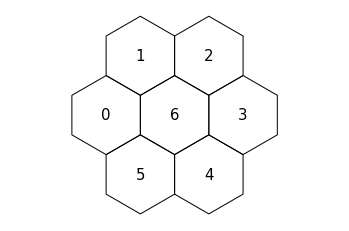

In [21]:
%run hexagonmap.py

In [22]:
# hexagon-like connectivity
hex_connectivity = np.zeros((7, 7))
i = np.arange(7)
hex_connectivity[i[:-1], i[:-1]+1] = 1
hex_connectivity[i[1:], i[1:]-1] = 1
hex_connectivity[-1, :] = 1
hex_connectivity[:, -1] = 1
hex_connectivity[5, 0] = 1
hex_connectivity[0, 5] = 1
hex_connectivity[6,6] = 0
fig_hex_connectivity = plt.figure()
plt.spy(hex_connectivity)
plt.close()

In [23]:
time, solution_hex = run_two_dimensional_sheet(tmax, model, hex_connectivity * gamma_ephaptic)

In [24]:
corr_mat_hex = calc_correlation_matrix(solution_hex, threshold)
mean_corr_hex = corr_mat_hex[hex_connectivity == 1].mean()
fig_corr_hex = plot_correlation_matrix(corr_mat_hex, mean_corr_hex)
plt.close()

In [25]:
pli_hex = calc_pli(solution_hex, dt, cutoff_frequency=0.8)
mean_pli_hex = pli_hex[hex_connectivity==1].mean()
fig_pli_hex = plot_pli_matrix(pli_hex, mean_pli_hex)
plt.close()

In [26]:
svg = sc.Figure('15cm', '11cm',sc.SVG('hexagonmap.svg').scale(0.7).move(-30, 30),
                              sc.MplFigure(fig_corr_hex, transparent=True)
                                 .scale(0.75).move(-40, 220),
                              sc.MplFigure(fig_hex_connectivity, transparent=True)
                                 .scale(0.75).move(250, 20),
                              sc.MplFigure(fig_pli_hex, transparent=True)
                                 .scale(0.75).move(250, 220),
                              sc.Text('A', 10, 50, size=18, weight='bold'),
                              sc.Text('B', 280, 50, size=18, weight='bold'),
                              sc.Text('C', 10, 250, size=18, weight='bold'),
                              sc.Text('D', 280, 250, size=18, weight='bold')                            

               )
svg

**Figure** Ephaptic-based synchronisation in the hexagonal topology (two dimensional). **A**. We simulated seven E/I populations (labeled 0 &mdash; 6) on a hexagonal grid. The populations interacted through electric field (ephaptic interaction) only with their closest neighbours. **B**. Connectivity matrix. Black squares denote connected pairs. **C**. Pairwise correlation matrix between all pairs of populations. Largest correlations are with the closest neigbours (dark brown). The mean correlation between direct neigbours, $\bar{r}$, is given in the top-right corner. **D**. Phase locking index across all pairs and its average across connected pairs, $\Phi$.

## Compare correlations

In [ ]:
r_ring = np.unique(corr_mat_ring[ring_connectivity == 1])
r_chain = np.unique(corr_mat_chain[chain_connectivity == 1])
r_hex = np.unique(corr_mat_hex[hex_connectivity == 1])

pli_ring_neigh = np.unique(pli_ring[ring_connectivity == 1])
pli_chain_neigh = np.unique(pli_chain[chain_connectivity == 1])
pli_hex_neigh = np.unique(pli_hex[hex_connectivity == 1])

In [ ]:
def despine(ax):
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_position(('outward', 20))

In [ ]:
r_means = []
pli_means = []
jitter = 0.2
fig_means, axes = plt.subplots(1, 2, figsize=(7, 3), gridspec_kw = {'wspace':0.8})

for i, y in enumerate([r_chain, r_ring, r_hex]):
    axes[0].plot(np.ones(len(y)) * i + np.random.rand(len(y)) * jitter, y, 'o')
    r_means.append(y.mean())    
    
for i, y in enumerate([pli_chain_neigh, pli_ring_neigh, pli_hex_neigh]):
    axes[1].plot(np.ones(len(y)) * i + np.random.rand(len(y)) * jitter, y, 'o')
    pli_means.append(y.mean())    
    
    
axes[0].plot(r_means, color='k')
axes[1].plot(pli_means, color='k')

for ax in axes:
    ax.set_xticks(range(3))
    ax.set_xticklabels(['chain', 'ring', 'hexagon'])
    despine(ax)

axes[0].set_ylabel("Pearson's r")
axes[1].set_ylabel('PLI')
plt.close()

In [ ]:
svg = sc.Figure("13cm", "6cm", 
                sc.MplFigure(fig_means),
                sc.Text("A", 10, 25, size=18, weight="bold"),
                sc.Text("B", 250, 25, size=18, weight="bold")
               )
svg

**Figure** Comparison of correlation coefficient and phase locking index across toplogies, one-dimensional chain and ring, two-dimensional hexagon. (**A**) Pearson's correlation coefficient. (**B**) Phase locking index, PLI.